<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/neural%20network/00_NN_Recommender_system_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive
    import tensorflow as tf
    print("Versión de TensorFlow:", tf.__version__)
    print("Dispositivos disponibles:", tf.config.list_physical_devices())

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

    path_workspace = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)

    # Verificar la GPU
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print('GPU no encontrada')
    print(f'Encontrada GPU: {device_name}')

    # Habilitar la GPU para TensorFlow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print('Memoria de la GPU configurada dinámicamente')
    else:
        print('No se encontraron dispositivos GPU configurables')
else:
    print("El código se está ejecutando en un entorno local.")
    path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path


sys.path.append(path_workspace)

El código se está ejecutando en un entorno local.


## Se cargan las librerías

In [2]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import Utils.utils as util
import matplotlib.pyplot as plt
import tensorflow_probability as tfp


from keras import backend as K
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense,Dropout,Flatten,Embedding,BatchNormalization,Concatenate,Add,Concatenate,Dot,Input,dot,concatenate

## METRICS FUNCTIONS

In [3]:
def precision(recommended_items, relevant_items):
    # Calculate the intersection of recommended_items and relevant_items
    true_positive = len(set(recommended_items).intersection(set(relevant_items)))

    # Calculate the total number of recommended items
    total_recommended_items = len(recommended_items)

    # Calculate precision
    precision_value = true_positive / total_recommended_items if total_recommended_items > 0 else 0
    return precision_value

# Example usage
recommended_items = [1, 3, 5, 7, 9]
relevant_items = [2, 3, 5, 7, 11, 15, 20]

precision_value = precision(recommended_items, relevant_items)
print(f"Precision: {precision_value:.2f}")


Precision: 0.60


In [4]:
def precisionK(recommended_items, relevant_items, k):
    """
    Calcula la precisión en k (Precision@k) dadas las recomendaciones y los elementos relevantes.

    :param recommended_items: Una lista de los elementos recomendados.
    :param relevant_items: Una lista de los elementos relevantes para el usuario.
    :param k: El número de elementos principales a considerar.
    :return: La precisión en k.
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo.")

    if len(recommended_items) == 0:
        return 0

    # Tomamos solo los primeros k elementos recomendados
    recommended_at_k = recommended_items[:k]

    # Contamos el número de elementos relevantes entre los k recomendados
    relevantes_entre_k = sum(1 for item in recommended_at_k if item in relevant_items)

    # Calculamos la precisión en k
    precision_at_k = relevantes_entre_k / k

    return precision_at_k

In [5]:
def recall(recommended_items, relevant_items):
    # Calculate the intersection of recommended_items and relevant_items
    true_positive = len(set(recommended_items).intersection(set(relevant_items)))

    # Calculate the total number of relevant items
    total_relevant_items = len(relevant_items)

    # Calculate recall
    recall_value = true_positive / total_relevant_items if total_relevant_items > 0 else 0
    return recall_value

# Example usage
recommended_items = [1, 3, 5, 7, 9]
relevant_items = [2, 3, 5, 7, 11, 15, 20]

recall_value = recall(recommended_items, relevant_items)
print(f"Recall: {recall_value:.2f}")

Recall: 0.43


In [6]:
def recallK(recommended_items, relevant_items, k):
    """
    Calcula el Recall en k (Recall@k) o Hit Ratio en k (HitRatio@k) dadas las recomendaciones y los elementos relevantes.

    :param recommended_items: Una lista de los elementos recomendados.
    :param relevant_items: Una lista de los elementos relevantes para el usuario.
    :param k: El número de elementos principales a considerar.
    :return: El Recall en k.
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo.")

    if len(relevant_items) == 0:
        return 0

    # Tomamos solo los primeros k elementos recomendados
    recommended_at_k = recommended_items[:k]

    # Contamos el número de elementos relevantes entre los k recomendados
    relevantes_entre_k = sum(1 for item in recommended_at_k if item in relevant_items)

    # Calculamos el Recall en k
    recall_at_k = relevantes_entre_k / len(relevant_items)

    return recall_at_k

# Ejemplo de uso
recommended_items_ejemplo = ['a', 'b', 'c', 'd', 'e']
relevant_items_ejemplo = ['b', 'd', 'f']

k_ejemplo = 3

recall_k_ejemplo = recallK(recommended_items_ejemplo, relevant_items_ejemplo, k_ejemplo)
print("Recall@{}: {:.2f}".format(k_ejemplo, recall_k_ejemplo))


Recall@3: 0.33


In [7]:
def mean_reciprocal_rank(recommended_items_list, relevant_items_list):
    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    reciprocal_ranks = []

    # Iterate through the lists of recommended items and relevant items for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        # print(f"recommended_items --> {recommended_items}")
        # print(f"relevant_items --> {relevant_items}")
        # Find the reciprocal rank for each user
        for rank, item in enumerate(recommended_items, start=1):
          # print(f"rank --> {rank}")
          # print(f"item --> {item}")
          if item in relevant_items:
              reciprocal_ranks.append(1 / rank)
              break
          else:
              reciprocal_ranks.append(0)

    # Calculate the mean reciprocal rank
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
    return mrr

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

relevant_items_list = [
    [2, 3, 5, 7, 11],
    [1, 4, 6, 8, 9],
    [16, 17, 18, 19, 20]
]

mrr = mean_reciprocal_rank(recommended_items_list, relevant_items_list)
print(f"Mean Reciprocal Rank: {mrr:.2f}")


Mean Reciprocal Rank: 0.12


In [8]:
def average_precision(recommended_items, relevant_items):
    true_positives = 0
    sum_precisions = 0
    # print(f"AVP_recommended_items --> {recommended_items}")
    # print(f"AVP_relevant_items --> {relevant_items}")
    for rank, item in enumerate(recommended_items, start=1):
      # print(f"AVP_rank --> {rank}")
      # print(f"AVP_item --> {item}")
      if item in relevant_items:
          true_positives += 1
          precision_at_rank = true_positives / rank
          sum_precisions += precision_at_rank
      # print(f"AVP_sum_precisions --> {sum_precisions}")

    return sum_precisions / len(relevant_items) if len(relevant_items) > 0 else 0

def mean_average_precision(recommended_items_list, relevant_items_list):
    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    average_precisions = []

    # Calculate the average precision for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        ap = average_precision(recommended_items, relevant_items)
        average_precisions.append(ap)

    # Calculate the mean average precision across all users
    map_value = sum(average_precisions) / len(average_precisions)
    return round(map_value, 2)

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

relevant_items_list = [
    [2, 3, 5, 7, 11],
    [1, 4, 6, 8, 9],
    [16, 17, 18, 19, 20]
]

map_value = mean_average_precision(recommended_items_list, relevant_items_list)
print(f"Mean Average Precision: {map_value}")

Mean Average Precision: 0.29


In [9]:
def discounted_cumulative_gain(recommended_items, relevant_items):
    dcg = 0
    # print(f'\ndiscounted_cumulative_gain --> recommended_items {recommended_items}')
    # print(f'discounted_cumulative_gain --> relevant_items {relevant_items}\n')
    for i, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            dcg += 1 / (math.log2(i + 1))
    return dcg

def ideal_discounted_cumulative_gain(recommended_items, relevant_items):
    # print(f'ideal_discounted_cumulative_gain --> recommended_items {recommended_items}')
    # print(f'ideal_discounted_cumulative_gain --> relevant_items {relevant_items}\n')
    sorted_relevant_items = sorted(relevant_items, key=lambda x: recommended_items.index(x) if x in recommended_items else float('inf'))
    return discounted_cumulative_gain(sorted_relevant_items, relevant_items)

def normalized_discounted_cumulative_gain(recommended_items, relevant_items):
    # print(f'\nnormalized_discounted_cumulative_gain --> recommended_items {recommended_items}')
    # print(f'normalized_discounted_cumulative_gain --> relevant_items {relevant_items}')
    dcg = discounted_cumulative_gain(recommended_items, relevant_items)
    idcg = ideal_discounted_cumulative_gain(recommended_items, relevant_items)

    if idcg == 0:
        return 0
    else:
        return round(dcg / idcg, 2)

def mean_normalized_discounted_cumulative_gain(recommended_items, relevant_items):
  # print(f'\nmean_normalized_discounted_cumulative_gain --> recommended_items {recommended_items}')
  # print(f'mean_normalized_discounted_cumulative_gain --> relevant_items {relevant_items}')
  ndcg_values = [normalized_discounted_cumulative_gain(recommended, relevant)
                  for recommended, relevant in zip(recommended_items, relevant_items)]
  average_ndcg = np.mean(ndcg_values)
  return average_ndcg

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

relevant_items_list = [
    [2, 3, 5, 7, 11],
    [1, 4, 6, 8, 9],
    [16, 17, 18, 19, 20]
]

ndcg_values = [normalized_discounted_cumulative_gain(recommended, relevant)
               for recommended, relevant in zip(recommended_items_list, relevant_items_list)]

print(f"nDCG values: {ndcg_values}")

average_ndcg = mean_normalized_discounted_cumulative_gain(recommended_items_list, relevant_items_list)
print(f"nDCG promedio: {average_ndcg:.2f}")

nDCG values: [0.53, 0.53, 0.23]
nDCG promedio: 0.43


In [10]:
def catalog_coverage(recommended_items_list, catalog_items):
    # Flatten the list of recommended items and convert it to a set
    unique_recommended_items = set(item for sublist in recommended_items_list for item in sublist)

    # Calculate the intersection of unique recommended items and catalog items
    covered_items = unique_recommended_items.intersection(catalog_items)

    # Calculate the catalog coverage
    coverage = len(covered_items) / len(catalog_items)
    return coverage

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

catalog_items = set(range(1, 21))

coverage = catalog_coverage(recommended_items_list, catalog_items)
print(f"Catalog Coverage: {coverage}")

Catalog Coverage: 0.8


In [11]:
def prediction_coverage(predicted_ratings, total_users, total_items):

    print(f'predicted_ratings --> {predicted_ratings[0]}\n')
    print(f'total_users --> {total_users}\n')
    print(f'total_items --> {total_items}\n')


    # Count the number of user-item pairs for which the recommendation system can make predictions
    predicted_pairs = sum(len(ratings) for ratings in predicted_ratings)

    print(f'predicted_pairs --> {predicted_pairs}\n')
    # Calculate the total number of possible user-item pairs
    total_possible_pairs = total_users * total_items

    print(f'total_possible_pairs --> {total_possible_pairs}\n')
    # Calculate the prediction coverage
    coverage = predicted_pairs / total_possible_pairs

    print(f'coverage --> {coverage}\n')
    return coverage

# Example usage
predicted_ratings = [
    {1: 3.5, 3: 4.0, 5: 2.5, 7: 3.0, 9: 4.5},
    {2: 4.5, 4: 3.0, 6: 2.0, 8: 3.5},
    {11: 3.5, 12: 4.0, 13: 2.5, 14: 3.0, 15: 4.5, 16: 3.5, 17: 2.0}
]

total_users = 3
total_items = 20

coverage = prediction_coverage(predicted_ratings, total_users, total_items)
print(f"Prediction Coverage: {coverage:.2f}")


predicted_ratings --> {1: 3.5, 3: 4.0, 5: 2.5, 7: 3.0, 9: 4.5}

total_users --> 3

total_items --> 20

predicted_pairs --> 16

total_possible_pairs --> 60

coverage --> 0.26666666666666666

Prediction Coverage: 0.27


In [12]:
               # 1  2  3  4  5  6  7  8
archiqture = [1, 1, 1, 1, 1, 1, 1, 1, 1]

## Se cargan los Datasets

In [13]:
# dataFrame_onehot_encode = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs_onehot_encode.csv', sep=',')

# dataFrame_onehot_encode.head()

In [14]:
dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')
print(dataFrame_without_ohe.shape)
dataFrame_without_ohe.head()

C:\Users\jaime\AppData\Local\Temp\ipykernel_24588\4218327248.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')


(25000095, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
0,1,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1147880044,5.0
1,3,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1439474476,5.0
2,4,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1573938898,4.0
3,5,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,830786155,4.0
4,7,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,835444730,4.0


In [15]:
dataFrame_without_ohe_min_ratings = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs_min_ratins.csv')
print(dataFrame_without_ohe_min_ratings.shape)
dataFrame_without_ohe_min_ratings.head()
dataFrame = dataFrame_without_ohe_min_ratings.copy()

(56162, 8)


In [16]:
df = dataFrame.copy()
print(df.shape)
df.head()

(56162, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
0,521,296,"r:strong language, great cast excellent, ironi...","masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1279793342,5.0
1,741,296,"r:strong language, great cast excellent, ironi...","masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1262230676,4.0
2,1028,296,"r:strong language, great cast excellent, ironi...","masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1303088217,5.0
3,2057,296,"r:strong language, great cast excellent, ironi...","masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1432118815,4.5
4,2730,296,"r:strong language, great cast excellent, ironi...","masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1450742665,4.0


## Ordenar el dataFrame por la columna 'timestamp' de mayor a menor, de la claifición mas reciente a la más antigua.


In [17]:
dataFrame_sorted_by_timestamp = dataFrame.copy()

# Ordenar el DataFrame por la columna 'timestamp' de mayor a menor
dataFrame_sorted_by_timestamp = dataFrame_sorted_by_timestamp.sort_values(by='timestamp', ascending=False)

## Se eliminan las filas que tengan NaN en las columnas **tag_by_user** o **tag_genome**

In [18]:
def contar_valores_nulos(df):
    # Cuenta los valores nulos en cada columna del DataFrame
    valores_nulos_por_columna = df.isnull().sum()
    # Cuenta los valores nulos en todo el DataFrame
    total_valores_nulos = df.isnull().sum().sum()
    # Imprime la cantidad de valores nulos por columna
    print("Valores nulos por columna:")
    print(valores_nulos_por_columna)
    # Imprime el total de valores nulos en el DataFrame
    print("\nTotal de valores nulos en el dataset:", total_valores_nulos)

def eliminar_filas_nulas(df, columna):
    # Seleccionar las filas con valores nulos en la columna deseada
    filas_con_nulos = df[df[columna].isnull()]
    # Mostrar las filas con valores nulos
    # print("Filas con valores nulos en la columna", columna, ":")
    # print(filas_con_nulos)
    # Eliminar las filas con valores nulos en la columna deseada
    df = df.dropna(subset=[columna])
    return df

In [19]:
# contar_valores_nulos(df)
dataFrame_sorted_by_timestamp = eliminar_filas_nulas(dataFrame_sorted_by_timestamp, 'tag_genome')
# contar_valores_nulos(df)
dataFrame_sorted_by_timestamp = eliminar_filas_nulas(dataFrame_sorted_by_timestamp, 'tag_by_user')
# contar_valores_nulos(df)

In [20]:
print(dataFrame_sorted_by_timestamp.shape)
dataFrame_sorted_by_timestamp.head()

(54671, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
53748,73725,190401,"Scotland, coverup, netflix, dark, Netflix orig...","original, mentor, catastrophe, silly fun, grea...",Calibre (2018),Thriller,1574300676,3.0
30003,122409,1500,"hitman, rekindled love, romance, predictable, ...","comedy, hit men, hitman, off-beat comedy, assa...",Grosse Pointe Blank (1997),Comedy|Crime|Romance,1574276946,2.5
26209,160473,47,"Sloth, s.w.a.t., very good, Atmospheric, drug ...","powerful ending, police investigation, great e...",Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1574238626,4.5
19356,42965,79132,"menswear - outstanding, Orriginal screenplay, ...","complex, dreams, complicated, visually appeali...",Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,1574238008,5.0
38586,96399,2527,"AI, wissenschaftliche sci-fi, cyborgs, chase, ...","futuristic, robot, androids, future, robots",Westworld (1973),Action|Sci-Fi|Thriller|Western,1574219255,2.5


## Se toma un subDataset del original

In [21]:
dataFrame = dataFrame_sorted_by_timestamp.copy()
#Tomar una submuestra
# n_samples = round(dataFrame.shape[0] * 0.05)
# dataFrame = dataFrame.sample(n=n_samples, random_state=42)
df = dataFrame.copy()
print(df.shape)
df.head()

(54671, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
53748,73725,190401,"Scotland, coverup, netflix, dark, Netflix orig...","original, mentor, catastrophe, silly fun, grea...",Calibre (2018),Thriller,1574300676,3.0
30003,122409,1500,"hitman, rekindled love, romance, predictable, ...","comedy, hit men, hitman, off-beat comedy, assa...",Grosse Pointe Blank (1997),Comedy|Crime|Romance,1574276946,2.5
26209,160473,47,"Sloth, s.w.a.t., very good, Atmospheric, drug ...","powerful ending, police investigation, great e...",Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1574238626,4.5
19356,42965,79132,"menswear - outstanding, Orriginal screenplay, ...","complex, dreams, complicated, visually appeali...",Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,1574238008,5.0
38586,96399,2527,"AI, wissenschaftliche sci-fi, cyborgs, chase, ...","futuristic, robot, androids, future, robots",Westworld (1973),Action|Sci-Fi|Thriller|Western,1574219255,2.5


## MODELS

In [22]:

# La asignación de índices únicos y la posterior división del DataFrame en conjuntos de entrenamiento y
# prueba pueden ser necesarias por varias razones en el contexto de modelos de recomendación y
# aprendizaje automático en general:

# Índices numéricos: Algunos algoritmos y modelos de aprendizaje automático requieren que las
# entradas sean números enteros. Al asignar índices únicos a los usuarios y películas,
# se asegura de que cada entidad esté representada por un identificador numérico único,
# lo que facilita el procesamiento por parte de los modelos.

# Consistencia en los datos de entrada: Al asignar índices únicos y transformar los datos originales,
# se crea una representación consistente y única para cada usuario y película en el conjunto de datos.
# Esto facilita el manejo y la interpretación de los datos durante el preprocesamiento y el entrenamiento
# del modelo.

# Reproducibilidad: La división aleatoria del DataFrame en conjuntos de entrenamiento y
# prueba utilizando np.random.rand() con una semilla (random_state) proporciona reproducibilidad.
# Esto significa que si vuelves a ejecutar el código con la misma semilla, obtendrás la misma
# división de datos, lo que es útil para comparar resultados y depurar el código.

# Evaluación del modelo: La división en conjuntos de entrenamiento y prueba es esencial para
# evaluar el rendimiento del modelo. El conjunto de entrenamiento se utiliza para entrenar el modelo,
# mientras que el conjunto de prueba se reserva para evaluar su rendimiento en datos no vistos.

# En resumen, estas operaciones son prácticas comunes en el preprocesamiento de datos para modelos
# de aprendizaje automático, especialmente cuando se trata de conjuntos de datos que contienen
# variables categóricas o identificadores que deben ser representados de manera numérica y
# cuando se busca garantizar la consistencia y la reproducibilidad en el procesamiento de datos.

df_aux = df.copy()

# Crear diccionarios de asignación de índices únicos
user_unique_ids = df_aux['userId'].unique()
movie_unique_ids = df_aux['movieId'].unique()

userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# Aplicar la asignación de índices únicos al DataFrame
df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# Dividir dataset en entrenamiento y test
X = df_aux[['userId', 'movieId', 'genres']]  # UserId y movieId
Y = df_aux['rating']                # rating



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Resetear los índices de x_train y x_test
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

n_genres = 19
print(f'Usuarios unicos: {len(user_unique_ids)} y peliculas unicas {len(movie_unique_ids)}')
print(x_train.shape , x_test.shape)

Usuarios unicos: 6067 y peliculas unicas 6917
(43736, 3) (10935, 3)


In [23]:
# x_train

In [24]:
# y_train

### Definicicón de parametros

Primero probamos con unos parametros común para todos para obtner el modelo con mejores resultados usando los mimos parametros en todos.

In [25]:
# Definición del número de factores latentes
n_latent_factors = 10
# learning_rate = 5e-4
lr = 1e-3
#Función de perdida
loss_function = 'mse'
#Bartch
batch_size = 64
#Epoch
epochs = 150
#Paciencia early stopping
pte = 3

### FUNCIÓN EARLY STOPPING

In [26]:
es = EarlyStopping(monitor="val_loss",
                   mode="min",
                   verbose=1,
                   patience=pte)

### FUNCIÓN DE ENTRENAMIENTO DADO UN MODELO, DATOS DE ENTRENAMIENTO Y TEST

In [27]:
def train_model(model, x=None, y=None, x_test=None, y_test=None):
    # Definir los datos de entrada si no se proporcionan
    if x is None:
        x = [x_train['userId'], x_train['movieId']]
    if y is None:
        y = y_train
    if x_test is None:
        x_test = [x_test['userId'], x_test['movieId']] if x_test is not None else None  # Corrección aquí
    if y_test is None:
        y_test = y_test

    # Entrenar el modelo y obtener el objeto history
    history = model.fit(x=x, y=y,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[es])
    return history


### FUNCIÓN PARA MOSTRAS LAS GRÁFICAS DE PERDIDA

In [28]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax1 = plt.subplots(figsize=(6, 4))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss, 'r--', label='Training Loss')
    ax1.plot(val_loss, 'b-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Añadir leyendas
    ax1.legend(loc='upper left')

    fig.tight_layout()
    plt.title('Model Loss and Accuracy')
    plt.show()

### FUNCIONES PARA EL CALCULO DE METRICAS DE ERROR 

In [29]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def pearson_corr(y_true, y_pred):
    # Convertir y_pred a tipo float64
    y_pred = y_pred.astype(np.float64)
    # Calcular la correlación de Pearson
    return tfp.stats.correlation(y_true, y_pred, sample_axis=0, event_axis=1)


In [30]:
def calcular_metricas(model, x_test, y_test):
    # Obtener predicciones del modelo
    predictions = model.predict(x_test)

    # Aplanar predicciones
    predictions = predictions.ravel()

    # Calcular métricas
    rmse_val = rmse(y_test, predictions)
    mae_val = mae(y_test, predictions)
    mape_val = mape(y_test, predictions)
    mse_val = mse(y_test, predictions)
    r2_val = r2_score(y_test, predictions)
    # pearson_corr_val = pearson_corr(y_test, predictions)

    # Imprimir métricas
    print("\tRMSE:", rmse_val.numpy())
    print("\tMAE:", mae_val.numpy())
    print("\tMSE:", mse_val.numpy())
    print("\tR2 Score:", r2_val)
    print(f"\tMAPE: {mape_val.numpy()} %")
    # print("Pearson Correlation:", pearson_corr_val)

### Arquitectura 1

In [31]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [32]:
# Obtención del número único de usuarios y películas en el conjunto de datos de calificaciones
n_users, n_movies = len(df['userId'].unique()), len(df['movieId'].unique())

# Definición de la entrada del usuario
user_input = Input(shape=(1,), name='User_Input')

# Creación de la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users, output_dim=n_latent_factors, input_length=1,
                            name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)

# Definición de la entrada de la película
movie_input = Input(shape=(1,), name='Movie_Input')

# Creación de la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies, output_dim=n_latent_factors, input_length=1,
                             name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)

# Combinación de los vectores de usuario y película mediante el producto punto
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)

# Creación del modelo utilizando Model API de Keras
model_a1 = Model([user_input, movie_input], merged_vectors)

model_a1.summary()
# Visualizar el modelo de Keras en formato DOT y luego lo convierte a formato SVG para mostrarlo
# SVG(model_to_dot( model_a1,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

#Compilar modelo SGD,Adagrad,Adadelta,RMSprop
model_a1.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 10)        60670       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 10)        69170       ['Movie_Input[0][0]']            
                                                                                              

### Arquitectura 2

In [33]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [34]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='user_input', dtype='int64')

# Crear la capa de embedding para usuarios
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)  # Aplanar la salida de la capa de embedding
user_vec = Dropout(0.40)(user_vec)  # Aplicar Dropout para regularización

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')

# Crear la capa de embedding para películas
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)  # Aplanar la salida de la capa de embedding
movie_vec = Dropout(0.40)(movie_vec)  # Aplicar Dropout para regularización

# Calcular la similitud entre los vectores de usuario y película mediante el producto punto
similarity = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)

# Definir una capa de red neuronal para procesar la similitud calculada
nn_inp = Dense(96, activation='relu')(similarity)
nn_inp = Dropout(0.4)(nn_inp)  # Aplicar Dropout para regularización
# nn_inp = BatchNormalization()(nn_inp)  # Normalización por lotes (comentada, opcional)
nn_inp = Dense(1, activation='relu')(nn_inp)

# Crear el modelo utilizando Model API de Keras
model_a2 = Model([user_input, movie_input], nn_inp)
model_a2.summary()  # Mostrar resumen del modelo en términos de parámetros y capas

# Compilar el modelo con la función de pérdida y el optimizador especificados
model_a2.compile(loss=loss_function, optimizer= Adam(learning_rate=lr) )


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        60670       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        69170       ['movie_input[0][0]']            
                                                                                              

### Arquitectura 3

In [35]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [36]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='User_Input')

# Crear la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users+1, output_dim=n_latent_factors, input_length=1, name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)  # Aplanar la salida de la capa de embedding

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='Movie_input')

# Crear la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies+1, output_dim=n_latent_factors, input_length=1, name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)  # Aplanar la salida de la capa de embedding

# Concatenar los vectores de usuario y película
merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')

# Capa densa con 100 unidades y función de activación ReLU
dense_layer_1 = Dense(100, activation='relu')(merged_vectors)

# Aplicar Dropout para regularización
dense_layer_3 = Dropout(0.5)(dense_layer_1)

# Capa densa de salida con 1 unidad
dense_layer_2 = Dense(1)(dense_layer_3)

# Crear el modelo utilizando Model API de Keras
model_a3 = Model([user_input, movie_input], dense_layer_2)

# Compilar el modelo con la función de pérdida, el optimizador y métricas especificados
model_a3.compile(loss=loss_function, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
model_a3.summary()  # Mostrar resumen del modelo en términos de parámetros y capas


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 10)        60680       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 10)        69180       ['Movie_input[0][0]']            
                                                                                              

### Arquitectura 4

In [37]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [38]:
# Definición de la entrada del usuario (user_input)
user_input = Input(shape=[1], name='user')  # Capa de entrada para la información del usuario.
# print(f"User Input Shape: {user_input.shape}")

# Creación de la capa de embedding para usuarios (user_embedding)
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
# La capa de embedding asigna a cada usuario un vector en el espacio de factores latentes.
# print(f"User Embedding Shape: {user_embedding.shape}")

# Aplanamiento de la capa de embedding para usuarios (user_vec)
user_vec = Flatten(name='flatten_users')(user_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa al usuario en el espacio de factores latentes.
# print(f"Flattened User Vector Shape: {user_vec.shape}")

# Definición de la entrada de la película (movie_input)
movie_input = Input(shape=[1], name='movie')  # Capa de entrada para la información de la película.
# print(f"Movie Input Shape: {movie_input.shape}")

# Creación de la capa de embedding para películas (movie_embedding)
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
# La capa de embedding asigna a cada película un vector en el espacio de factores latentes.
# print(f"Movie Embedding Shape: {movie_embedding.shape}")

# Aplanamiento de la capa de embedding para películas (movie_vec)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa la película en el espacio de factores latentes.
# print(f"Flattened Movie Vector Shape: {movie_vec.shape}")

# Cálculo del producto punto entre los vectores de película y usuario (product)
product = dot([movie_vec, user_vec], axes=1)
# El modelo calcula el producto punto entre los vectores de película y usuario para predecir las calificaciones.
# print(f"Product Shape: {product.shape}")

# Definición del modelo (model)
model_a4 = Model(inputs=[user_input, movie_input], outputs=product)

# Compilación del modelo con la función de pérdida y optimizador
model_a4.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        69180       ['movie[0][0]']                  
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        60680       ['user[0][0]']                   
                                                                                              

### Arquitectura 5

In [39]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [40]:
# Definir la entrada del usuario y su embedding
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

# Definir la entrada de la película y su embedding
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Concatenar los embeddings de usuario y película
concatenated = concatenate([user_vec, movie_vec], name='Concatenation')

# Añadir capas Dense con activación ReLU
dense_layer1 = Dense(128, activation='relu')(concatenated)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer3 = Dense(32, activation='relu')(dense_layer2)

# Capa de salida con activación lineal
output = Dense(1, activation='linear')(dense_layer3)

# Crear el modelo con métrica R cuadrado
model_a5 = Model(inputs=[user_input, movie_input], outputs=output)

# Compilación del modelo con la función de pérdida y optimizador
model_a5.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        60680       ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        69180       ['movie[0][0]']                  
                                                                                              

### Arquitectura 6

In [41]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [42]:
user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)

user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)

user_bias = Embedding(n_users, 1, name="user_bias")(user_input)

item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)
item_bias = Embedding(n_movies, 1, name="item_bias")(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

dot_user_item = Dot(name="dot", axes=1)([user_vector, item_vector])
output = Add(name="add")([dot_user_item, user_bias, item_bias])
output = Flatten(name="flat")(output)

model_a6 = Model([user_input, item_input], output, name="model_x")

model_a6.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a6.summary()

Model: "model_x"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        60670       ['user_id[0][0]']                
                                                                                                  
 item_emb (Embedding)           (None, 1, 10)        69170       ['item_id[0][0]']                
                                                                                            

### Arquitectura 7

In [43]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [44]:
hidden_units = [128, 64]

user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)
user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)
item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)

concatenated = Concatenate(name="concat")([user_embedding, item_embedding])
out = Flatten(name="flat")(concatenated)

for n_hidden in hidden_units:
    out = Dense(n_hidden,
                       activation="relu")(out)
    out = Dropout(0.4)(out)
    out = BatchNormalization()(out)

out = Dense(1, activation="sigmoid", name="prediction")(out)

model_a7 = Model(inputs = [user_input, item_input],
                      outputs = out, name="model_y")

model_a7.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a7.summary()

Model: "model_y"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        60670       ['user_id[0][0]']                
                                                                                                  
 item_emb (Embedding)           (None, 1, 10)        69170       ['item_id[0][0]']                
                                                                                            

### Arquitectura 8

In [45]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [46]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Supongamos que tienes tus datos en las matrices 'usuarios', 'peliculas', 'generos' y 'calificaciones'
# 'usuarios', 'peliculas' y 'generos' son listas de IDs de usuarios, películas y géneros, respectivamente
# 'calificaciones' es una lista de calificaciones correspondientes a cada par usuario-película

# Convertir los datos de género a una lista de listas
generos_list = [generos.split('|') for generos in df_aux['genres']]

# Inicializar y ajustar el codificador one-hot
mlb = MultiLabelBinarizer()
generos_one_hot = mlb.fit_transform(generos_list)

#------------------------------------------------------------------------------
# # Asignar índices únicos a usuarios y películas
# user_unique_ids = df_aux['userId'].unique()
# movie_unique_ids = df_aux['movieId'].unique()

# userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
# movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# # Aplicar la asignación de índices únicos al DataFrame
# df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
# df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# # Dividir dataset en entrenamiento y test
# x_train, x_test, y_train, y_test = train_test_split(df_aux[['userId', 'movieId', 'genres']], df_aux['rating'], test_size=0.2, random_state=42)

# # Resetear los índices de x_train y x_test
# x_train.reset_index(drop=True, inplace=True)
# x_test.reset_index(drop=True, inplace=True)
#------------------------------------------------------------------------------

# Definir las capas de entrada
input_usuario = Input(shape=[1])
input_pelicula = Input(shape=[1])
input_genero = Input(shape=[generos_one_hot.shape[1]])  # Número de géneros únicos

# Definir las capas de embedding para usuarios y películas
embedding_usuario = Embedding(input_dim=len(user_unique_ids), output_dim=50)(input_usuario)
embedding_pelicula = Embedding(input_dim=len(movie_unique_ids), output_dim=50)(input_pelicula)

# Aplanar las capas de embedding
flat_usuario = Flatten()(embedding_usuario)
flat_pelicula = Flatten()(embedding_pelicula)

# Concatenar las capas de embedding con los géneros codificados one-hot
concat = Concatenate()([flat_usuario, flat_pelicula, input_genero])

# Agregar capas densas
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1)(dense2)

# Compilar el modelo
modelo_a8 = Model(inputs=[input_usuario, input_pelicula, input_genero], outputs=output)
# Generar la codificación one-hot de los géneros solo para las filas relevantes
generos_one_hot_train = generos_one_hot[x_train.index]
generos_one_hot_test = generos_one_hot[x_test.index]

# Compilar el modelo
modelo_a8.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelo_a8.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        303350      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        345850      ['input_2[0][0]']                
                                                                                              

# A1

Epoch 1/150


684/684 [==============================] - 4s 4ms/step - loss: 16.9593 - val_loss: 16.9599
Epoch 2/150
684/684 [==============================] - 2s 3ms/step - loss: 16.5773 - val_loss: 15.9194
Epoch 3/150
684/684 [==============================] - 2s 3ms/step - loss: 14.0114 - val_loss: 12.2822
Epoch 4/150
684/684 [==============================] - 2s 3ms/step - loss: 10.0030 - val_loss: 8.9852
Epoch 5/150
684/684 [==============================] - 2s 3ms/step - loss: 7.1986 - val_loss: 7.1328
Epoch 6/150
684/684 [==============================] - 2s 3ms/step - loss: 5.5270 - val_loss: 5.9998
Epoch 7/150
684/684 [==============================] - 2s 3ms/step - loss: 4.4162 - val_loss: 5.2248
Epoch 8/150
684/684 [==============================] - 2s 3ms/step - loss: 3.6214 - val_loss: 4.6658
Epoch 9/150
684/684 [==============================] - 2s 3ms/step - loss: 3.0276 - val_loss: 4.2464
Epoch 10/150
684/684 [==============================] - 2s 3ms/step - loss: 2.5701 - val_loss: 3

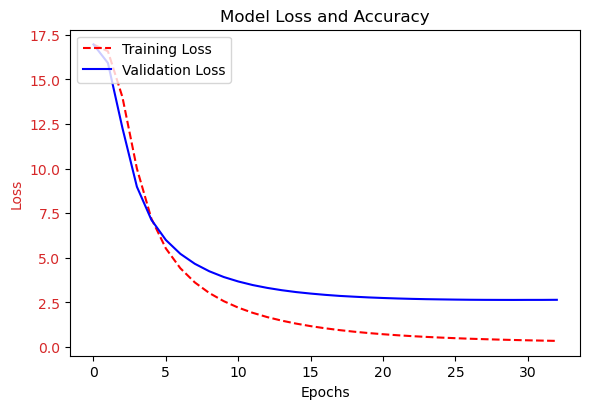

342/342 [==============================] - 1s 2ms/step
	RMSE: 1.627004655876117
	MAE: 1.0568588690973102
	MSE: 2.647144150242562
	R2 Score: -1.7133349181343291
	MAPE: 35.27930120961928 %


In [47]:
if archiqture[1] == 1:
    history_mda1 = train_model(model_a1, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda1)
    # Llamar a la función para calcular métricas
    calcular_metricas(model_a1, [x_test['userId'], x_test['movieId']], y_test)

# A2

Epoch 1/150
684/684 [==============================] - 4s 5ms/step - loss: 3.2866 - val_loss: 0.9775
Epoch 2/150
684/684 [==============================] - 2s 4ms/step - loss: 1.1843 - val_loss: 0.9784
Epoch 3/150
684/684 [==============================] - 3s 4ms/step - loss: 1.1364 - val_loss: 0.9831
Epoch 4/150
684/684 [==============================] - 3s 4ms/step - loss: 1.0732 - val_loss: 0.9964
Epoch 4: early stopping


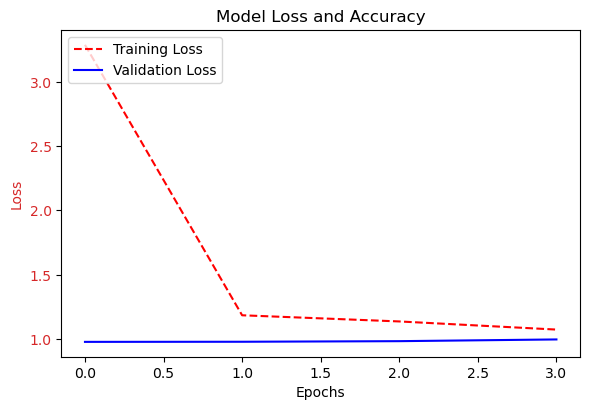

342/342 [==============================] - 1s 2ms/step
	RMSE: 0.9982119032614977
	MAE: 0.7661194091852691
	MSE: 0.9964270038129416
	R2 Score: -0.021342257681691956
	MAPE: 32.461836861755636 %


In [48]:
if archiqture[2] == 1:
    history_mda2 = train_model(model_a2, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda2)
    calcular_metricas(model_a2, [x_test['userId'], x_test['movieId']], y_test)

# A3

Epoch 1/150
684/684 [==============================] - 4s 4ms/step - loss: 2.9617 - accuracy: 0.0118 - val_loss: 0.8109 - val_accuracy: 0.0146
Epoch 2/150
684/684 [==============================] - 2s 4ms/step - loss: 0.9550 - accuracy: 0.0128 - val_loss: 0.7956 - val_accuracy: 0.0146
Epoch 3/150
684/684 [==============================] - 2s 4ms/step - loss: 0.8825 - accuracy: 0.0128 - val_loss: 0.7944 - val_accuracy: 0.0146
Epoch 4/150
684/684 [==============================] - 2s 4ms/step - loss: 0.8374 - accuracy: 0.0128 - val_loss: 0.7929 - val_accuracy: 0.0146
Epoch 5/150
684/684 [==============================] - 3s 4ms/step - loss: 0.8010 - accuracy: 0.0128 - val_loss: 0.8044 - val_accuracy: 0.0146
Epoch 6/150
684/684 [==============================] - 2s 4ms/step - loss: 0.7634 - accuracy: 0.0127 - val_loss: 0.7957 - val_accuracy: 0.0144
Epoch 7/150
684/684 [==============================] - 2s 4ms/step - loss: 0.7264 - accuracy: 0.0125 - val_loss: 0.8036 - val_accuracy: 0.0144

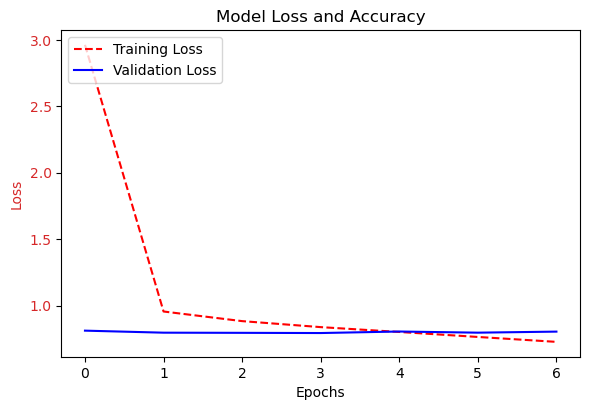

342/342 [==============================] - 1s 2ms/step
	RMSE: 0.896422000670947
	MAE: 0.6636042748867893
	MSE: 0.8035724032869033
	R2 Score: 0.1763345940614206
	MAPE: 27.139983461095866 %


In [49]:
if archiqture[3] == 1:
    history_mda3 = train_model(model_a3, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda3)
    calcular_metricas(model_a3, [x_test['userId'], x_test['movieId']], y_test)

# A4

Epoch 1/150
684/684 [==============================] - 3s 3ms/step - loss: 16.9561 - val_loss: 16.9360
Epoch 2/150
684/684 [==============================] - 2s 3ms/step - loss: 16.3155 - val_loss: 15.3151
Epoch 3/150
684/684 [==============================] - 2s 3ms/step - loss: 13.2695 - val_loss: 11.6201
Epoch 4/150
684/684 [==============================] - 2s 3ms/step - loss: 9.5186 - val_loss: 8.7190
Epoch 5/150
684/684 [==============================] - 2s 3ms/step - loss: 7.0022 - val_loss: 7.0424
Epoch 6/150
684/684 [==============================] - 2s 3ms/step - loss: 5.4347 - val_loss: 5.9799
Epoch 7/150
684/684 [==============================] - 2s 3ms/step - loss: 4.3609 - val_loss: 5.2398
Epoch 8/150
684/684 [==============================] - 2s 3ms/step - loss: 3.5778 - val_loss: 4.6995
Epoch 9/150
684/684 [==============================] - 2s 3ms/step - loss: 2.9842 - val_loss: 4.2907
Epoch 10/150
684/684 [==============================] - 2s 3ms/step - loss: 2.5224 - 

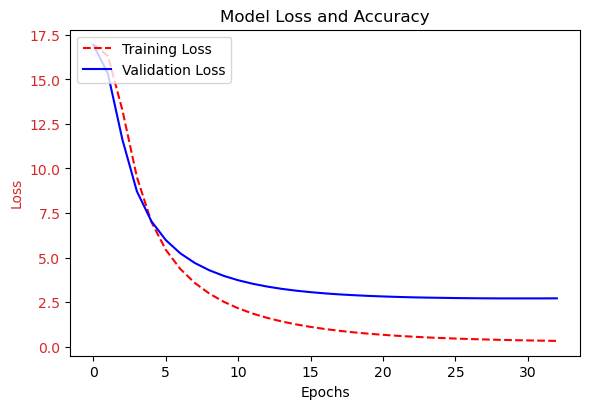

342/342 [==============================] - 1s 2ms/step
	RMSE: 1.6479689136472124
	MAE: 1.0866926795806406
	MSE: 2.7158015403475737
	R2 Score: -1.7837090584858584
	MAPE: 35.7005750274235 %


In [50]:
if archiqture[4] == 1:
    history_mda4 = train_model(model_a4, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda4)
    calcular_metricas(model_a4, [x_test['userId'], x_test['movieId']], y_test)

# A5

Epoch 1/150
684/684 [==============================] - 4s 4ms/step - loss: 1.3772 - val_loss: 0.7884
Epoch 2/150
684/684 [==============================] - 2s 4ms/step - loss: 0.6851 - val_loss: 0.7704
Epoch 3/150
684/684 [==============================] - 3s 4ms/step - loss: 0.6059 - val_loss: 0.7906
Epoch 4/150
684/684 [==============================] - 2s 4ms/step - loss: 0.5463 - val_loss: 0.8108
Epoch 5/150
684/684 [==============================] - 3s 4ms/step - loss: 0.4837 - val_loss: 0.8347
Epoch 5: early stopping


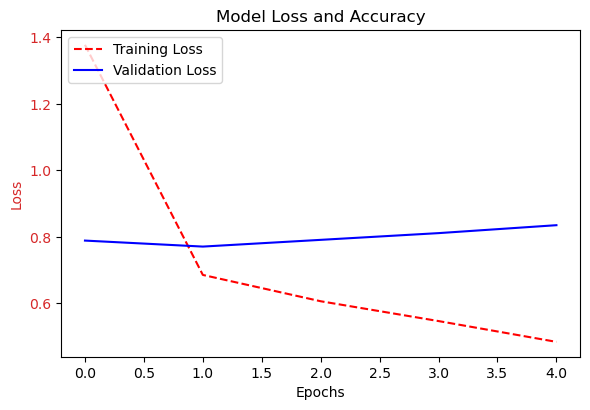

342/342 [==============================] - 1s 2ms/step
	RMSE: 0.9136224233888615
	MAE: 0.6634682749088463
	MSE: 0.8347059325189361
	R2 Score: 0.14442258353404158
	MAPE: 27.780889241556157 %


In [51]:
if archiqture[5] == 1:
    history_mda5 = train_model(model_a5, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda5)
    calcular_metricas(model_a5, [x_test['userId'], x_test['movieId']], y_test)

# A6

Epoch 1/150
684/684 [==============================] - 4s 4ms/step - loss: 15.9962 - val_loss: 15.0019
Epoch 2/150
684/684 [==============================] - 2s 3ms/step - loss: 13.4845 - val_loss: 11.7479
Epoch 3/150
684/684 [==============================] - 2s 3ms/step - loss: 9.4326 - val_loss: 7.8987
Epoch 4/150
684/684 [==============================] - 2s 3ms/step - loss: 6.2212 - val_loss: 5.7832
Epoch 5/150
684/684 [==============================] - 2s 4ms/step - loss: 4.4779 - val_loss: 4.6332
Epoch 6/150
684/684 [==============================] - 2s 3ms/step - loss: 3.4355 - val_loss: 3.9105
Epoch 7/150
684/684 [==============================] - 2s 3ms/step - loss: 2.7419 - val_loss: 3.4168
Epoch 8/150
684/684 [==============================] - 2s 3ms/step - loss: 2.2507 - val_loss: 3.0663
Epoch 9/150
684/684 [==============================] - 2s 3ms/step - loss: 1.8887 - val_loss: 2.8082
Epoch 10/150
684/684 [==============================] - 2s 4ms/step - loss: 1.6133 - va

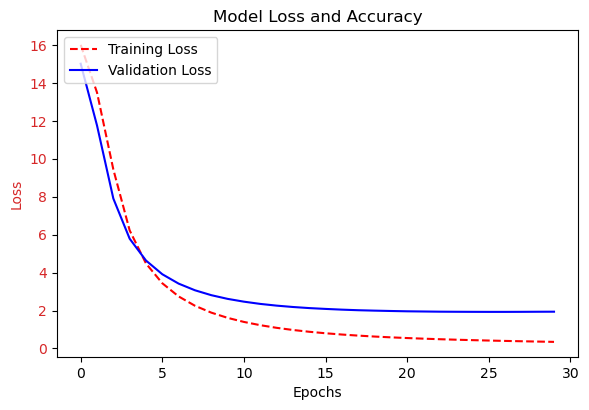

342/342 [==============================] - 1s 2ms/step
	RMSE: 1.3919184324452227
	MAE: 0.9398879175953768
	MSE: 1.937436922580766
	R2 Score: -0.9858817485399913
	MAPE: 32.518818660664245 %


In [52]:
if archiqture[6] == 1:
    history_mda6 = train_model(model_a6, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda6)
    calcular_metricas(model_a6, [x_test['userId'], x_test['movieId']], y_test)

# A7

Epoch 1/150
684/684 [==============================] - 5s 5ms/step - loss: 10.5697 - val_loss: 9.9835
Epoch 2/150
684/684 [==============================] - 3s 5ms/step - loss: 9.9767 - val_loss: 9.9807
Epoch 3/150
684/684 [==============================] - 4s 5ms/step - loss: 9.9697 - val_loss: 9.9801
Epoch 4/150
684/684 [==============================] - 3s 5ms/step - loss: 9.9682 - val_loss: 9.9799
Epoch 5/150
684/684 [==============================] - 3s 5ms/step - loss: 9.9677 - val_loss: 9.9798
Epoch 6/150
684/684 [==============================] - 4s 5ms/step - loss: 9.9674 - val_loss: 9.9798
Epoch 7/150
684/684 [==============================] - 3s 5ms/step - loss: 9.9672 - val_loss: 9.9798
Epoch 8/150
684/684 [==============================] - 3s 5ms/step - loss: 9.9673 - val_loss: 9.9797
Epoch 9/150
684/684 [==============================] - 4s 5ms/step - loss: 9.9671 - val_loss: 9.9797
Epoch 10/150
684/684 [==============================] - 3s 5ms/step - loss: 9.9671 - val_l

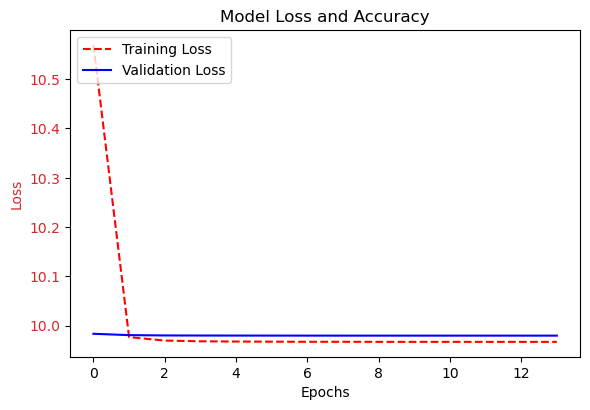

342/342 [==============================] - 1s 2ms/step
	RMSE: 3.1590700603849884
	MAE: 3.0135806604940485
	MSE: 9.979723646420815
	R2 Score: -9.229262596327898
	MAPE: 73.30604648244609 %


In [53]:
if archiqture[7] == 1:
    history_mda7 = train_model(model_a7, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda7)
    calcular_metricas(model_a7, [x_test['userId'], x_test['movieId']], y_test)

# A8

In [70]:
# if archiqture[8] == 1:
#     # history_mda8 = modelo_a8.fit([x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, epochs=10, batch_size=128, validation_data=([x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test))
#     history_mda8 = train_model(modelo_a8, [x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, [x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test)
#     plot_loss(history_mda8)
#     calcular_metricas(modelo_a8, [x_test['userId'], x_test['movieId']], y_test, generos_one_hot[dfUser_test.index])


## Evaluación de Modelos de Recomendación para Usuarios con Múltiples Calificaciones

 Utiliza varios modelos de recomendación para predecir las calificaciones que este usuario podría otorgar a otras películas, proporcionando una evaluación exhaustiva del rendimiento de los modelos para usuarios activos.

In [55]:
x_test

,userId,movieId,genres
0,350,1641,Drama|Horror|Thriller
1,2692,2709,Crime|Drama|Mystery|Thriller
2,322,1350,Comedy
3,3818,143,Comedy|Crime
4,766,571,Horror
...,...,...,...
10930,2379,804,Action|Adventure|Comedy|Crime
10931,4906,1063,Action|Adventure|Fantasy|Horror
10932,4094,340,Drama
10933,2836,357,Comedy|Crime|Thriller


In [56]:
y_test

0        4.5
1        3.5
2        4.0
3        3.0
4        3.5
        ... 
10930    4.0
10931    2.5
10932    4.5
10933    5.0
10934    3.5
Name: rating, Length: 10935, dtype: float64

#### ELEGIR LOS MODELOS O EL MODELO QUE MEJOR RESULTADO DE EN METRICAS DE ERROR

In [71]:
lista_modelos = [model_a3, model_a5, model_a6]

In [72]:
def unificar_predicciones(df_real, predicciones):
    # Ordenar el DataFrame de calificaciones reales por rating de manera descendente
    df_ordenado = df_real.sort_values(by='rating', ascending=False)
    df_real = df_ordenado.reset_index(drop=True)
    df_real = df_real[['userId', 'movieId', 'rating']]

    # Convertir la lista de predicciones a un DataFrame
    df_predicciones = pd.DataFrame(predicciones, columns=['rating_predicho'])

    # Reiniciar el índice de df_test_by_unq_user para asegurar que coincida con el índice de predicciones
    df_test_by_unq_user_reset = df_real.reset_index(drop=True)

    # Agregar la columna de índices (movieId) al DataFrame de predicciones
    df_predicciones['movieId_predict'] = df_test_by_unq_user_reset['movieId']

    # Ordenar el DataFrame de predicciones por rating de manera descendente
    df_predicciones_ordenado = df_predicciones.sort_values(by='rating_predicho', ascending=False)
    df_predicciones_ordenado = df_predicciones_ordenado.reset_index(drop=True)

    # Ordenar por rating_predicho
    df_predicciones_ordenado = df_predicciones_ordenado.sort_values(by='rating_predicho', ascending=False)

    # Concatenar horizontalmente
    df_concatenado = pd.concat([df_real, df_predicciones_ordenado], axis=1)

    # Reordenar columnas y renombrar
    df_concatenado = df_concatenado[['userId', 'movieId', 'rating', 'rating_predicho', 'movieId_predict']]

    return df_concatenado

In [73]:
user = random.choice(x_test['userId'].index)
x_test[(x_test['userId'] == user)]


,userId,movieId,genres
4840,5525,5886,Adventure|Comedy|Musical


In [74]:
#Concatenar el dataframe de test con el objeto series de claificaciones
df_x_test_y_test_concat = pd.concat([x_test, y_test], axis=1)
#Obtenemos un dataframe para un único usuario
dfUser_test= df_x_test_y_test_concat.loc[df_x_test_y_test_concat['userId'] == user]
#Obtenemos un objeto Series con la columna rating a predecir.
rating_df_user = dfUser_test['rating']
# rating_df_user

In [75]:
# Ordenar el DataFrame de calificaciones reales por rating de manera descendente
dfUser_test_real_order_by_rating = dfUser_test.sort_values(by='rating', ascending=False)
dfUser_test_real = dfUser_test_real_order_by_rating.copy()
dfUser_test_real = dfUser_test_real.reset_index(drop=True)
dfUser_test_real = dfUser_test_real[['userId', 'movieId', 'rating']]
# print(dfUser_test_real)

In [76]:
def get_relevant_value_by_user(calificaciones):
  # Se van a obtner el número de elementos relevantes para un usario
  # Se decide que un elemento es relevante para unusuario si lo ha calificado con más de 3'5, es decir elementos
  # calificados con 4, 4'5 y 5. Cualquier calificación real inferior a 3,5 es irrelevante
  # Inicializamos un contador para el número de elementos relevantes
  relevantes = 0

  # Iteramos sobre las calificaciones
  for calificacion in calificaciones:
    # Si la calificación es mayor que 3.5, consideramos el elemento como relevante
    if calificacion >= 3.5:
      relevantes += 1
  return relevantes

In [77]:
def obtain_true_dataframe_test_by_user(x_test, y_test, user_id):
  #Concatenar el dataframe de test con el objeto series de claificaciones
  dfTets_x_y = pd.concat([x_test, y_test], axis=1)
  #Obtenemos un dataframe para un único usuario
  dfTest_by_user= dfTets_x_y.loc[dfTets_x_y['userId'] == user_id]

  # Ordenar el DataFrame de calificaciones reales por rating de manera descendente
  dfTest_by_user_order_rating = dfTest_by_user.sort_values(by='rating', ascending=False)
  dfTets_Real_by_user = dfTest_by_user_order_rating.copy()
  dfTets_Real_by_user = dfTets_Real_by_user.reset_index(drop=True)
  dfTets_Real_by_user = dfTets_Real_by_user[['userId', 'movieId', 'rating']]
  return dfTets_Real_by_user


In [78]:
def obtain_precission_recall_by_user(df_test_true_uq_user, modelo):
  predicciones = modelo.predict([df_test_true_uq_user['userId'], df_test_true_uq_user['movieId']], verbose=0)
  # print(f"Mtricas de predicción: ")
  # calcular_metricas(modelo, [x_test['userId'], x_test['movieId']], y_test)

  df_unificado = unificar_predicciones(df_test_true_uq_user, predicciones)

  num_relevant_values = get_relevant_value_by_user(df_unificado['rating'])

  relevants_movvies_per_user = list(df_unificado['movieId'][:num_relevant_values])

  precision_value_k_point = precisionK(list(df_unificado['movieId_predict']),
                                       relevants_movvies_per_user, 5)

  recall_value_k_point = recallK(list(df_unificado['movieId_predict']),
                                 relevants_movvies_per_user, 5)

  # print(f"Precisión@K: {precision_value_k_point:.2f}")
  # print(f"Recall@K: {recall_value_k_point:.2f}\n")

  return precision_value_k_point, recall_value_k_point, relevants_movvies_per_user, list(df_unificado['movieId_predict']), predicciones


In [79]:
# Obtener la lista de usuarios únicos
lista_usuarios_unicos = x_test['userId'].unique()
num_user_uq = len(lista_usuarios_unicos)
# Iteramos sobre las calificaciones
list_recomendeds = []
list_relevants = []
list_predictions_ratings = []

for i, modelo in enumerate(lista_modelos, start=1):
  if archiqture[i] == 1:
    print(f"-------------------> MODELO {i}")
    for unique_user in lista_usuarios_unicos:
      dfTets_true_by_user = obtain_true_dataframe_test_by_user(x_test, y_test, unique_user)
      precsion, recall, relevant_items_list, recommended_items_list, predicted_ratings = obtain_precission_recall_by_user(dfTets_true_by_user, modelo)
      list_recomendeds.append(recommended_items_list)
      list_relevants.append(relevant_items_list)
      list_predictions_ratings.append(predicted_ratings)

    mrr = mean_reciprocal_rank(list_recomendeds, list_relevants)
    map_value = mean_average_precision(list_recomendeds, list_relevants)
    ndcg_avg = mean_normalized_discounted_cumulative_gain(list_recomendeds, list_relevants)
    catalog_items = set(x_test['movieId'])
    coverage = catalog_coverage(list_recomendeds, catalog_items)

    print(f"MRR: {mrr:.2f}\n")
    print(f"MAP: {map_value:.2f}\n")
    print(f"nDGC Average: {ndcg_avg:.2f}\n")
    print(f"Catalog Coverage: {coverage}")

-------------------> MODELO 1
MRR: 0.84

MAP: 0.89

nDGC Average: 0.90

Catalog Coverage: 1.0
-------------------> MODELO 2
MRR: 0.84

MAP: 0.89

nDGC Average: 0.90

Catalog Coverage: 1.0
-------------------> MODELO 3
MRR: 0.84

MAP: 0.89

nDGC Average: 0.90

Catalog Coverage: 1.0


In [66]:
len(catalog_items)

3435

In [67]:
# # Mostrar algunas predicciones de cada uno de los modelos, dado un subDataframe de un usuario
# for i, modelo in enumerate(lista_modelos, start=1):
#     if archiqture[i] == 1:
#         if i == 8:
#             predicciones = modelo.predict([dfUser_test['userId'], dfUser_test['movieId'], generos_one_hot[dfUser_test.index]])
#         else:
#             predicciones = modelo.predict([dfUser_test['userId'], dfUser_test['movieId']])
#         # print(f"Predicciones del modelo {i}:")
#         # df_unificado = unificar_predicciones(dfUser_test_real, predicciones)
#         # print(df_unificado)

In [68]:
# # Ordenar el DataFrame de calificaciones reales por rating de manera descendente
# df_ordenado = df_test_by_unq_user.sort_values(by='rating', ascending=False)
# df_real = df_ordenado.copy()
# df_real = df_real.reset_index(drop=True)
# df_real = df_real[['userId', 'movieId', 'rating']]
# # Convertir la lista de predicciones a un DataFrame
# df_predicciones = pd.DataFrame(predicciones, columns=['rating_predicho'])

# # Reiniciar el índice de df_test_by_unq_user para asegurar que coincida con el índice de predicciones
# df_test_by_unq_user_reset = df_test_by_unq_user.reset_index(drop=True)

# # Agregar la columna de índices (movieId) al DataFrame de predicciones
# df_predicciones['movieId_predict'] = df_test_by_unq_user_reset['movieId']

# # Ordenar el DataFrame de predicciones por rating de manera descendente
# df_predicciones_ordenado = df_predicciones.sort_values(by='rating_predicho', ascending=False)
# df_predicciones_ordenado = df_predicciones_ordenado.reset_index(drop=True)
# # Convertir a DataFrame
# df_real = df_real
# df_predicho = df_predicciones_ordenado

# # Ordenar por rating_predicho
# df_predicho = df_predicho.sort_values(by='rating_predicho', ascending=False)

# # Concatenar horizontalmente
# df_concatenado = pd.concat([df_real, df_predicho], axis=1)

# # Reordenar columnas y renombrar
# df_concatenado = df_concatenado[['userId', 'movieId', 'rating', 'rating_predicho', 'movieId_predict']]


# df_concatenado.head(5)

